In [1]:
import s3fs
import xarray as xr
import xesmf
import numpy as np

In [2]:
# USER DEFINED INPUTS!
# define the name of our S3 bucket
bucket_name = 'eis-dh-hydro/SNOWEX-HACKWEEK'

# define path to store on S3
lis_output_s3_path_time_chunk = f's3://{bucket_name}/2022/ZARR/SURFACEMODEL/LIS_HIST_rechunkedV4.d01.zarr'
lis_output_s3_path = f's3://{bucket_name}/2022/ZARR/SURFACEMODEL/LIS_HIST_default_chunks.d01.zarr/'

# specify filters
time_sel='2020-01-01'
lat_range = [38.6, 38.8]
lon_range = [-108.6, -108.4]

model_variable = 'SM_SWE_inst'

dx = 0.001

In [3]:
# create S3 filesystem object
s3 = s3fs.S3FileSystem(anon=False)

# create key-value mapper for S3 object (required to read data stored on S3)
lis_output_mapper = s3.get_mapper(lis_output_s3_path)
lis_output_mapper_tc = s3.get_mapper(lis_output_s3_path_time_chunk)

# open the dataset
lis_output_ds = xr.open_zarr(lis_output_mapper, consolidated=True)
lis_output_ds_tc = xr.open_zarr(lis_output_mapper_tc, consolidated=True)

In [4]:
lis_output_ds = lis_output_ds.sel(time=time_sel)

lis_output_ds = lis_output_ds.where((lis_output_ds.lat >=  lat_range[0]) & 
                                    (lis_output_ds.lat <= lat_range[1]) &
                                    (lis_output_ds.lon >=  lon_range[0]) &
                                    (lis_output_ds.lon <=  lon_range[1]) ,drop=True)

In [5]:
lis_output_ds = lis_output_ds.rename_dims({'east_west':'x','north_south':'y'})
ds_out = xesmf.util.grid_2d(lis_output_ds['lon'].min(),lis_output_ds['lon'].max(),dx,
                            lis_output_ds['lat'].min(),lis_output_ds['lat'].max(),dx)
regridder = xesmf.Regridder(lis_output_ds,ds_out,"bilinear")
outt = regridder(lis_output_ds[model_variable])
outt

<xarray.DataArray (y: 205, x: 209)>
dask.array<_regrid, shape=(205, 209), dtype=float32, chunksize=(205, 209), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2020-01-01
    lat      (y, x) float64 38.6 38.6 38.6 38.6 38.6 ... 38.8 38.8 38.8 38.8
    lon      (y, x) float64 -108.6 -108.6 -108.6 -108.6 ... -108.4 -108.4 -108.4
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear

In [10]:
out_reproj = outt.assign_coords({'longitude':outt['lon'][0,:],'latitude':outt['lat'][:,0]})
out_reproj = out_reproj.rename({'x':'longitude','y':'latitude'})
out_reproj = out_reproj.rio.write_crs(4326)

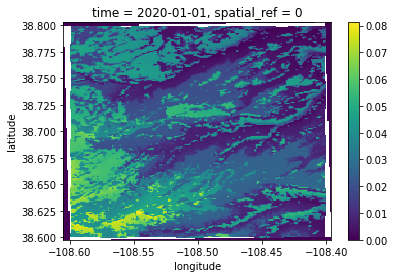

In [12]:
out_reproj.plot()